In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#If you're not familiar with this, save it! Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
df = pd.read_csv('data.csv')
df.head()

,acousticness,artists,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,speechiness,tempo,valence
0,0.926,Bob Dylan,0.615,277107.0,0.114,6QHYEZlm9wyfXfEM1vSu1P,0.000004,8,0.1660,-17.285,1,Boots of Spanish Leather,0.0357,101.189,0.401
1,0.919,Bob Dylan,0.567,412200.0,0.198,7ny2ATvjtKszCpLpfsGnVQ,0.000871,4,0.1350,-18.681,1,A Hard Rains A-Gonna Fall,0.0327,92.467,0.321
2,0.206,Bob Dylan,0.579,177200.0,0.479,0wfBooQ6QtDm63UIyIcDIj,0.002110,5,0.1630,-10.348,1,John Wesley Harding,0.0294,135.459,0.937
3,0.565,Bob Dylan,0.666,389800.0,0.617,5ka7NFOlZUpVLJmA2tO0o4,0.000000,7,0.0498,-10.851,1,Bob Dylans 115th Dream,0.0628,105.648,0.764
4,0.571,Bob Dylan,0.702,171107.0,0.560,2FDTgrYDUdQKyGmtynEk90,0.000000,4,0.1090,-12.323,1,Love Minus Zero,0.0342,125.452,0.889


Here we look at the boxplots for the values already in the 0-1 range. This is representitave of the entire dataset but would be very interesting to see the results on clustering.

In [5]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

<AxesSubplot:>

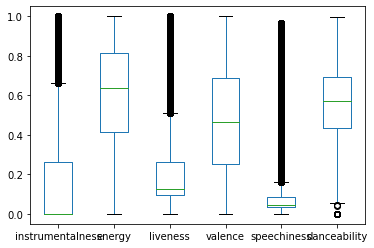

In [6]:
df[['instrumentalness','energy', 'liveness', 'valence', 'speechiness', 'danceability']].plot.box()

Keys describe the pitch class that a song falls into. I am not by any means a musician, so I don't really understand what this means, but it seems we have 12 different pitch classes. This may or may not be helpful in song recommendation.

<AxesSubplot:ylabel='Frequency'>

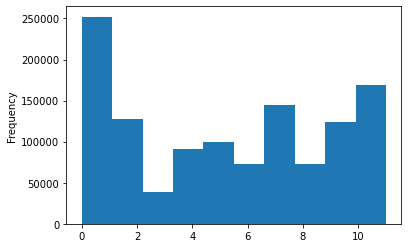

In [7]:
df['key'].plot.hist()

I want to see how long or short songs are. As we can see there are a few outliers on the low and high end. Let's do a bit more investigation and then remove the outliers.

In [8]:
(df['duration_ms']/1000).describe().apply(lambda x: format(x, 'f'))

count    1193421.000000
mean         244.755962
std          142.859521
min            1.000000
25%          186.615000
50%          225.240000
75%          274.840000
max         6014.408000
Name: duration_ms, dtype: object

In [9]:
# only show top 20
df[df['duration_ms'] < 10000][:20]

,acousticness,artists,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,speechiness,tempo,valence
13511,0.818,Kindred The Family Soul,0.0,7027.0,0.28300,0JRpfu9AyGgyn7EoJIHqzk,0.000000,0,0.000,-18.423,0,Entertain the Peoplez (Interlude),0.0,0.0,0.0
29504,0.980,Michael Jackson,0.0,9280.0,0.20200,4LmoG8VPVL0qGj1dM6qQjf,0.000000,10,0.270,-14.536,1,Seasons Greetings From Michael Jackson,0.0,0.0,0.0
41068,0.618,John Mayer,0.0,7229.0,0.07210,4Fz1WWr5o0OrlIcZxcyZtK,0.694000,2,0.000,-22.480,1,On The Way Home,0.0,0.0,0.0
43747,0.921,The Cinematic Orchestra,0.0,6840.0,0.01480,7mmnsnu3OITlbWHK9yJTjx,0.952000,1,0.000,-37.730,1,The Projectionist,0.0,0.0,0.0
46963,0.956,Childish Gambino,0.0,4800.0,0.72900,2jQIzjFeqCT3jOUi3dIlWB,0.831000,2,0.000,-21.200,1,The Library - Intro,0.0,0.0,0.0
46982,0.834,D.Glover,0.0,9169.0,0.37500,72FOoaFLS7BChLXylQszEA,0.000000,8,0.614,-12.944,1,Royalty,0.0,0.0,0.0
58211,0.685,Elizabeth Debicki,0.0,9453.0,0.23500,4ImiLH0o8YR38WXtCLdclM,0.000000,10,0.853,-16.987,1,"""I Like Large Parties""",0.0,0.0,0.0
58212,0.856,Leonardo Dicaprio,0.0,8893.0,0.71900,6LnmAegLvTeiX5ZdQp75R8,0.000000,10,0.366,-19.155,0,"""Cant Repeat The Past?""",0.0,0.0,0.0
58213,0.551,Green Light,0.0,7547.0,0.00562,42s3fRB19vclAu3CFy91Kn,0.956000,0,0.000,-32.353,1,Green Light,0.0,0.0,0.0
71203,0.521,Michael Bublé,0.0,4520.0,0.05940,3hww6gm2UvMGim9inNmw58,0.052200,1,0.000,-20.736,0,Michaels Christmas Greeting,0.0,0.0,0.0


Above we are looking songs that are 10 seconds or shorter. For example, "Seasons Greetings From Michael Jackson" by Michael Jackson is 9 seconds of young Michael Jackson wishing everyone a happy holidays. Another example is "THE SEX - Intro" by Tove Lo. This is a 6 second clip of her saying something. 

For the purposes of this project, I have decided that I am considering a song to be an audio sample longer than two minutes. 

As for the really long songs, I also don't want to include those that are too long. As a reference, "Stairway to Heaven - Remaster" by LEd Zeppelin is 8:02 and "Runaway" by Kanye West is 9:07. These are two really long songs I know off the top of my head. Since Runaway is longer, let's consider 9:08 to be the cutoff. This means anything longer than 548 seconds should be discarded.

To highlight why I am doing this, I am seeking to remove things that aren't really songs. Here are a couple examples I found: "Deep Sleep 5 - Ambient Music Therapy" by Ambient Music Therapy, "Troll Mix Vol 1" by Krewella, "Sonata No. 10 C major, KV 330 (1783)..." by Relaxing Classical Piano Music Ensamble. As you can see, there are mixes, concerts, and other very long pieces that we don't want to consider as individual songs. Of course, some actual songs that happen to be long will be removed, but I believe it is more important to remove the non-songs. We removed 19,326 tracks.

In [97]:
# too long
remove = df[df['duration_ms'] > 548000]
print('removing {} tracks'.format(remove.shape[0]))
df = df[df['duration_ms'] < 548000]

removing 19326 tracks


In [98]:
# too short
remove = df[df['duration_ms'] < 120000]
print('removing {} tracks'.format(remove.shape[0]))
df = df[df['duration_ms'] > 120000]

removing 59730 tracks


In [99]:
(df['duration_ms']/1000).describe().apply(lambda x: format(x, 'f'))

count    1114225.000000
mean         242.336174
std           74.307655
min          120.001000
25%          192.427000
50%          227.867000
75%          274.960000
max          547.987000
Name: duration_ms, dtype: object

Let's mess with some clustering to see if we can identify genres among the songs. I am going to avoid PCA because we are not seeing a lower dimensional representation of the data; I think the set of features we have now is small enough. I am also not going to try K-Means Clustering immediately because I am not sure how many Genres I want to have. Let's have a go at hierarchial clustering to see how many genres would be appropriate.

In [100]:
df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06
mean,3.195208e-01,5.615466e-01,2.423362e+05,6.083334e-01,1.843611e-01,5.270601e+00,2.052520e-01,-8.912365e+00,6.525684e-01,8.615404e-02,1.208578e+02,4.784595e-01
std,3.369318e-01,1.773840e-01,7.430765e+04,2.530273e-01,3.249217e-01,3.562704e+00,1.846798e-01,5.010846e+00,4.761545e-01,1.030092e-01,2.928183e+01,2.629184e-01
min,0.000000e+00,0.000000e+00,1.200010e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.890000e-02,4.450000e-01,1.924270e+05,4.320000e-01,0.000000e+00,2.000000e+00,9.540000e-02,-1.090900e+01,0.000000e+00,3.490000e-02,9.797700e+01,2.600000e-01
50%,1.730000e-01,5.740000e-01,2.278670e+05,6.460000e-01,2.310000e-04,5.000000e+00,1.270000e-01,-7.664000e+00,1.000000e+00,4.680000e-02,1.200850e+02,4.670000e-01
75%,6.030000e-01,6.940000e-01,2.749600e+05,8.190000e-01,1.830000e-01,8.000000e+00,2.580000e-01,-5.545000e+00,1.000000e+00,8.420000e-02,1.392110e+02,6.920000e-01
max,9.960000e-01,9.940000e-01,5.479870e+05,1.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00,4.764000e+00,1.000000e+00,9.660000e-01,2.499870e+02,1.000000e+00


Let's scale all our quantitative variables to have a standard deviation of 1. This will be helpful for the hierarchial clustering.

In [101]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
df[cols_to_scale] = StandardScaler().fit_transform(df[cols_to_scale])

df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06,1.114225e+06
mean,9.921437e-17,-1.396508e-15,2.423362e+05,6.952459e-16,2.104733e-16,5.270601e+00,-1.231337e-16,9.344532e-16,6.525684e-01,-2.427745e-16,9.970093e-16,-1.213762e-15
std,1.000000e+00,1.000000e+00,7.430765e+04,1.000000e+00,1.000000e+00,3.562704e+00,1.000000e+00,1.000000e+00,4.761545e-01,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.483251e-01,-3.165713e+00,1.200010e+05,-2.404221e+00,-5.674019e-01,0.000000e+00,-1.111395e+00,-1.019542e+01,0.000000e+00,-8.363729e-01,-4.127402e+00,-1.819803e+00
25%,-8.922306e-01,-6.570303e-01,1.924270e+05,-6.968949e-01,-5.674019e-01,2.000000e+00,-5.948245e-01,-3.984628e-01,0.000000e+00,-4.975680e-01,-7.814003e-01,-8.309027e-01
50%,-4.348678e-01,7.020577e-02,2.278670e+05,1.488639e-01,-5.666909e-01,5.000000e+00,-4.237174e-01,2.491327e-01,1.000000e+00,-3.820442e-01,-2.639243e-02,-4.358577e-02
75%,8.413553e-01,7.467044e-01,2.749600e+05,8.325848e-01,-4.189068e-03,8.000000e+00,2.856189e-01,6.720156e-01,1.000000e+00,-1.896961e-02,6.267775e-01,8.121935e-01
max,2.007764e+00,2.437951e+00,5.479870e+05,1.547923e+00,2.510264e+00,1.100000e+01,4.303387e+00,2.729354e+00,1.000000e+00,8.541437e+00,4.409876e+00,1.983660e+00


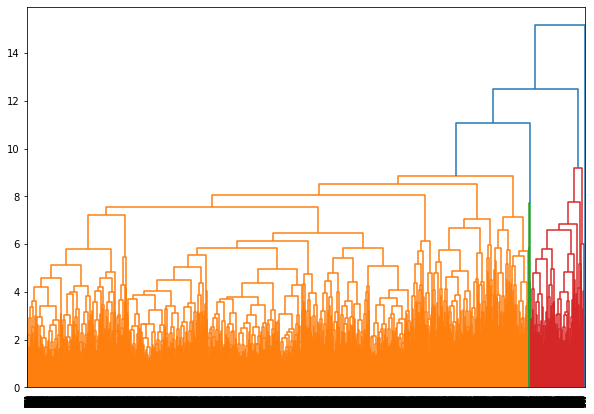

In [102]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

subset = df[cols_to_scale].iloc[0:10000,:]
linked = linkage(subset, 'complete')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=range(0, subset.shape[0]),
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

https://www.cs.princeton.edu/courses/archive/fall08/cos436/Duda/C/sk_means.htm

Okay, just kidding. Hierarchial clustering uses O(n^2) time and memory complexity. We cannot even come close to affording that for 1 Million tracks. The kernel dies when I try. We can see the dendrogram with just 10,000 tracks is extremely messy. I've looked into clustering algorithms and it seems like my best bet is to use sequential K-means. Sequential allows me to avoid some of the time and memory complexities to be O(nm) where n is the number of tracks and m is the number of centroids. The two biggest problems with this method are:

(1) I have to decide ahead of time how many genres I want to represent
(2) poor centroid initialization will incorrect genres where tracks are not placed correctly

to combat these, I will try to decide on the right number of genres based on online research and initialize the centroids randomly based on the spread of the data. 

10/21 update: I have implemented sequential k-means and calculate the distortion (average sum of squared distnaces for clusters, not counting empty clusters) to generate an elbow graph. I am using a subset of 1000 songs which is about 1% of the data. I am not sure whether or not this is a fair approximation or not, but going much larger takes way too long so we need to approximate. 

Let's run this a few times to see the results

In [201]:
%run sequential\ k\ means.ipynb

def run_01():
    subset = df.sample(n=1000, replace=False)
    k_vals = range(6, 60, 2)
    distortions = []
    empty = []
    for k in k_vals:
        [centroids, sizes, clusters, distortion] = sequential_k_means(subset, k)
        percent_empty = np.round(sizes.count(0)/len(sizes)*100, 3)
        empty.append(percent_empty)
    #     print('k={}:\t{}% empty clusters'.format(k, percent_empty))
        distortions.append(distortion)
    plot_performance(distortions, k_vals, empty)

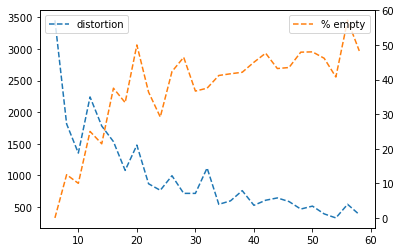

In [202]:
run_01()

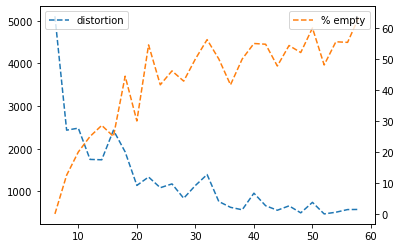

In [203]:
run_01()

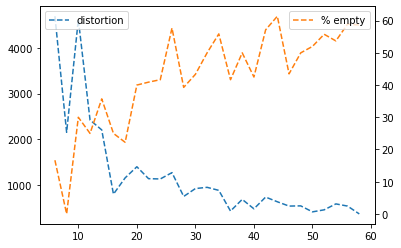

In [204]:
run_01()

We see that these graphs are all prettye similar despite sampling a different 1% of the data each time. Therefore, I am going to assume the right number of clusters we choose here is going to fairly well represent the dataset overall. Based on these results, I am seeing 30-40 genres as the best decision. But of course there are two things to toggle: the centroid initialization and the step length centroids take on update. Let's modify the step to be a constant rather than a decreasing factor and see how the results change.

In [208]:
%run sequential\ k\ means.ipynb

def run_02():
    subset = df.sample(n=1000, replace=False)
    k_vals = range(6, 60, 2)
    distortions = []
    empty = []
    for k in k_vals:
        [centroids, sizes, clusters, distortion] = sequential_k_means(subset, k, divisor=2)
        percent_empty = np.round(sizes.count(0)/len(sizes)*100, 3)
        empty.append(percent_empty)
    #     print('k={}:\t{}% empty clusters'.format(k, percent_empty))
        distortions.append(distortion)
    plot_performance(distortions, k_vals, empty)

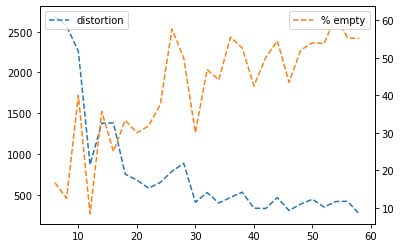

In [209]:
run_02()

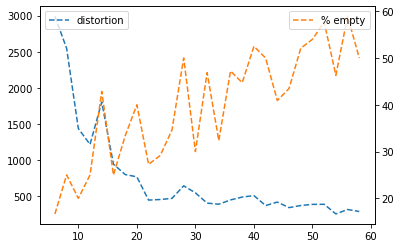

In [210]:
run_02()

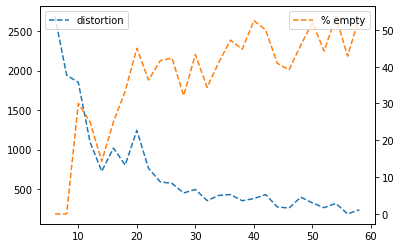

In [211]:
run_02()

Interesting! We see that the distortions are much lower now, indicating a constant step is better to find better placed centroids. While we have better centroids, I am still inclined to say 30-40 genres is the best choice. We are getting a good performance on distortion and while the percentage of empty clusters is high, the difference doesnt seem significant compared to a decreasing step size. For fun, let's overstep and see if it has any consequences.

In [212]:
%run sequential\ k\ means.ipynb

def run_03():
    subset = df.sample(n=1000, replace=False)
    k_vals = range(6, 60, 2)
    distortions = []
    empty = []
    for k in k_vals:
        [centroids, sizes, clusters, distortion] = sequential_k_means(subset, k, divisor=(1/3))
        percent_empty = np.round(sizes.count(0)/len(sizes)*100, 3)
        empty.append(percent_empty)
    #     print('k={}:\t{}% empty clusters'.format(k, percent_empty))
        distortions.append(distortion)
    plot_performance(distortions, k_vals, empty)

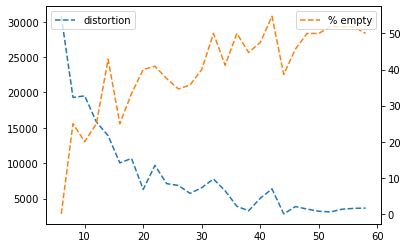

In [213]:
run_03()

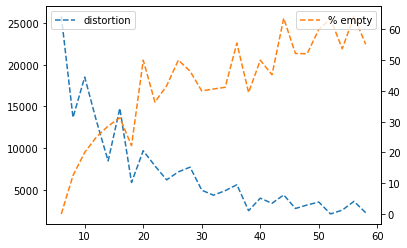

In [214]:
run_03()

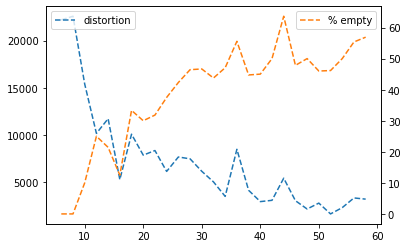

In [215]:
run_03()

The only interesting result here is that the distortions are now much higher. The interpretations are the same. Now, let's modify the initializations. Previously I have chosen a uniform random sample from the range of the 9 features. Instead of this, let's grab a random normal sample.

In [218]:
%run sequential\ k\ means.ipynb

def run_04():
    subset = df.sample(n=1000, replace=False)
    k_vals = range(6, 60, 2)
    distortions = []
    empty = []
    for k in k_vals:
        [centroids, sizes, clusters, distortion] = sequential_k_means(subset, k, sample='random')
        percent_empty = np.round(sizes.count(0)/len(sizes)*100, 3)
        empty.append(percent_empty)
    #     print('k={}:\t{}% empty clusters'.format(k, percent_empty))
        distortions.append(distortion)
    plot_performance(distortions, k_vals, empty)

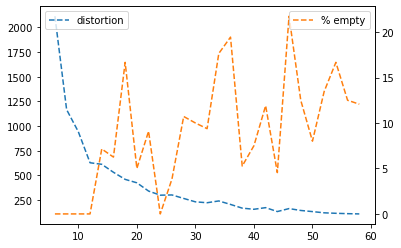

In [219]:
run_04()

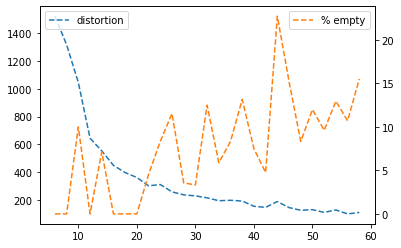

In [220]:
run_04()

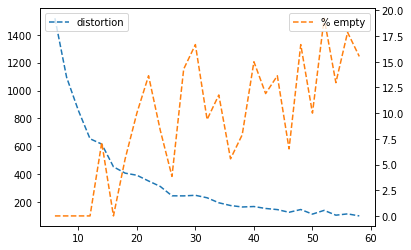

In [221]:
run_04()

Okay, some really interesting results here. We are able to achieve much lower distortions and percentage of empty clusters. It seems uniform random choices were placed in locations far from actual centroids. Now, the graph is elbowing around 15 clusters. Let's see how this changes if we use a constant step.

In [222]:
%run sequential\ k\ means.ipynb

def run_05():
    subset = df.sample(n=1000, replace=False)
    k_vals = range(6, 60, 2)
    distortions = []
    empty = []
    for k in k_vals:
        [centroids, sizes, clusters, distortion] = sequential_k_means(subset, k, divisor=2, sample='random')
        percent_empty = np.round(sizes.count(0)/len(sizes)*100, 3)
        empty.append(percent_empty)
    #     print('k={}:\t{}% empty clusters'.format(k, percent_empty))
        distortions.append(distortion)
    plot_performance(distortions, k_vals, empty)

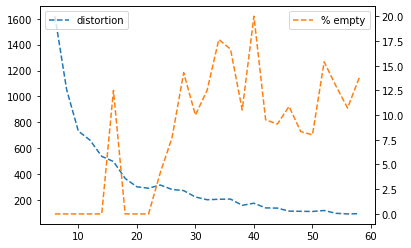

In [223]:
run_05()

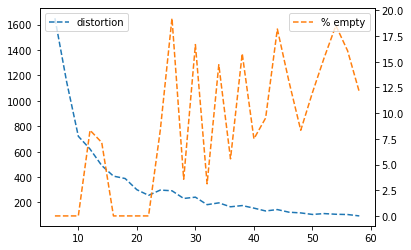

In [224]:
run_05()

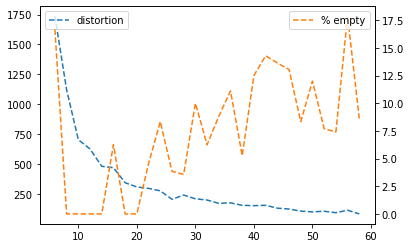

In [225]:
run_05()

Here we see the divisor has no imppact on performance. Moving forward, let's use a normal random initialization with 15 genres and see how it does! Next step is actual recommendation.